## Analysis strain on 041018 data
Data was collected on WS2 multilayer samples

In [5]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
import scipy.io as sio
from scipy import signal
import numpy.linalg

In [3]:
ExpPath = '/srv/home/chenyu/DEbackup/042219/S2/'
ExpName = 'S2'
rx = 150;
ry = 150;
PACBED = np.zeros((512,512))
for irow in range(ry):
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
        PACBED = PACBED + Sample

PACBED = PACBED / rx / ry
np.save(ExpPath + 'Averaged_diffraction.npy',PACBED)

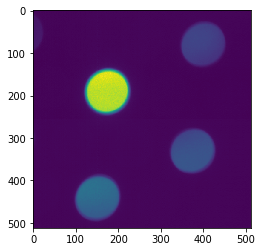

In [7]:
ExpPath = '/srv/home/chenyu/DEbackup/042219/S2/'
ExpName = 'S2'
rx = 150
ry = 150
PACBED = np.load(ExpPath + 'Averaged_diffraction.npy')
plt.imshow(PACBED)

In [65]:
ExpPath = '/srv/home/chenyu/DEbackup/042219/S2/'
ExpName = 'S2'
rx = 150
ry = 150
PACBED = np.load(ExpPath + 'Averaged_diffraction.npy')
mask = np.heaviside(PACBED[120:250,110:240]-150,1)   # generate mask from zero beam
mask_fft = np.fft.fft2(np.pad(mask, (191,191), 'constant', constant_values=(0, 0)))   # generate FT mask for convolution
x_loc = np.zeros((rx,ry,4))   # create matrix to hold all 4 x/y locations
y_loc = np.zeros((rx,ry,4))
for irow in range(ry):
    if irow % 10 ==0:
        print("Now working on row " + str(irow))
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
        Sample_conv = FrameConv(Sample, mask_fft)
        (loc_x,loc_y) = DiskLocate(Sample_conv)
        if loc_x.shape[0]==4:
            x_loc[irow,icol,:] = np.asarray([x for _,x in sorted(zip(loc_y,loc_x))])
            y_loc[irow,icol,:] = np.sort(loc_y)
        else:
            x_loc[irow,icol,:] = x_loc[irow,icol-1,:]
            y_loc[irow,icol,:] = y_loc[irow,icol-1,:]

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


In [93]:
from scipy.linalg import polar
g1_ref = np.mean(np.mean(x_loc[0:40,-40:,0] - x_loc[0:40,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[0:40,-40:,0] - y_loc[0:40,-40:,1],axis=0),axis=0)

g2_ref = np.mean(np.mean(x_loc[0:40,-40:,2] - x_loc[0:40,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[0:40,-40:,2] - y_loc[0:40,-40:,1],axis=0),axis=0)

irow = 100
icol = 100
g1 = x_loc[irow,icol,0] - x_loc[irow,icol,1], y_loc[irow,icol,0] - y_loc[irow,icol,1]
g2 = x_loc[irow,icol,2] - x_loc[irow,icol,1], y_loc[irow,icol,2] - y_loc[irow,icol,1]
F = linalg.solve([g1_ref,g2_ref],[g1,g2])
print(F)
r,u = polar(F)
print(r)
print(u)

[[ 0.95356581  0.05841041]
 [-0.05082632  1.01805496]]
[[ 0.99846869  0.05531969]
 [-0.05531969  0.99846869]]
[[0.95491731 0.00200248]
 [0.00200248 1.01972725]]


In [94]:
from scipy.linalg import polar
# Create reference with top right corner
g1_ref = np.mean(np.mean(x_loc[0:40,-40:,0] - x_loc[0:40,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[0:40,-40:,0] - y_loc[0:40,-40:,1],axis=0),axis=0)

g2_ref = np.mean(np.mean(x_loc[0:40,-40:,2] - x_loc[0:40,-40:,1],axis=0),axis=0),\
np.mean(np.mean(y_loc[0:40,-40:,2] - y_loc[0:40,-40:,1],axis=0),axis=0)

Eaa = np.zeros((150,150))
Ebb = np.zeros((150,150))
Eab = np.zeros((150,150))
Erot = np.zeros((150,150))

for irow in range(ry):
    if irow % 10 ==0:
        print("Now working on row " + str(irow))
    for icol in range(rx):
        g1 = x_loc[irow,icol,0] - x_loc[irow,icol,1], y_loc[irow,icol,0] - y_loc[irow,icol,1]
        g2 = x_loc[irow,icol,2] - x_loc[irow,icol,1], y_loc[irow,icol,2] - y_loc[irow,icol,1]
        F = linalg.solve([g1_ref,g2_ref],[g1,g2])
        R,U = polar(F) # polar decomposition F=RU, R is the first output as default
        Eaa[irow,icol] = 1 - U[0,0]
        Ebb[irow,icol] = 1 - U[1,1]
        Eab[irow,icol] = U[0,1]
        Erot[irow,icol] = np.arcsin(R[0,1])   # asin in radian

Now working on row 0
Now working on row 10
Now working on row 20
Now working on row 30
Now working on row 40
Now working on row 50
Now working on row 60
Now working on row 70
Now working on row 80
Now working on row 90
Now working on row 100
Now working on row 110
Now working on row 120
Now working on row 130
Now working on row 140


(0.0, 150.0, 0.0, 150.0)

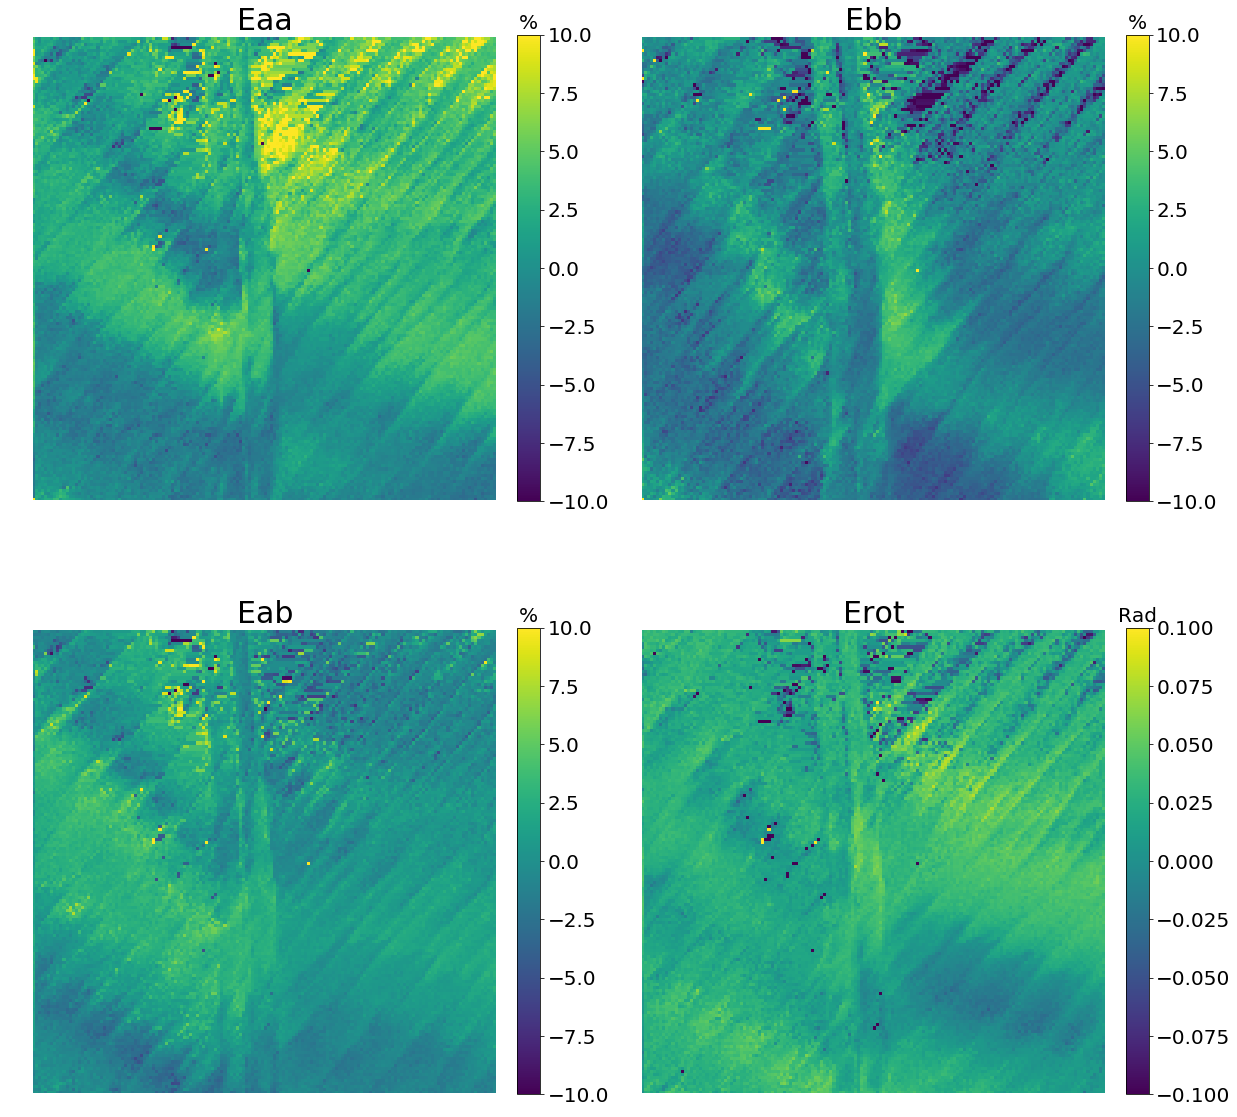

In [110]:
fig = plt.figure(figsize=(20,20))

fig.add_subplot(2,2,1)
im0 = plt.imshow(Eaa*100,clim=[-10,10])
plt.title('Eaa',fontsize=30)
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('%', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
plt.axis('off')

fig.add_subplot(2,2,2)
im0 = plt.imshow(Ebb*100,clim=[-10,10])
plt.title('Ebb',fontsize=30)
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('%', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
plt.axis('off')

fig.add_subplot(2,2,3)
im0 = plt.imshow(Eab*100,clim=[-10,10])
plt.title('Eab',fontsize=30)
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('%', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
plt.axis('off')

fig.add_subplot(2,2,4)
im0 = plt.imshow(Erot,clim=[-0.1,0.1])
plt.title('Erot',fontsize=30)
plt.xlim([0,150])
plt.ylim([0,150])
cbar = plt.colorbar(im0, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Rad', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
plt.axis('off')

In [2]:
def FrameConv(Sample, mask_fft):
    Sample_fft = np.fft.fft2(Sample)
    Sample_conv = np.fft.fftshift(np.fft.ifft2(Sample_fft * mask_fft))
    Sample_conv = Sample_conv.real
    return(Sample_conv)

In [3]:
def DiskLocate(im):
    image_max = ndi.maximum_filter(im, size=100, mode='constant')
    coordinates = peak_local_max(im, min_distance=50)
    coordinates = coordinates[0:4]   # only use top four positions
    peaks_x_fit = coordinates[:,1]
    peaks_y_fit = coordinates[:,0]
#     peaks_x_fit = []
#     peaks_y_fit = []
#     for i in range(coordinates.shape[0]):

#         x = int(coordinates[i][1])
#         y = int(coordinates[i][0])

#         patch = im[y-50:y+50,x-50:x+50]
#         bg = np.amin(patch)
#         guess = (bg,patch[50,50]-bg,50, 50, 30, 30)
#         bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,100,100,np.inf,np.inf])
#         param = fitGaussianx2(patch, guess, bounds)

#         peaks_x_fit.append(param[2]+x-50)
#         peaks_y_fit.append(param[3]+y-50)
        
    return (peaks_x_fit, peaks_y_fit)

[374 172 384] [335 192  82]


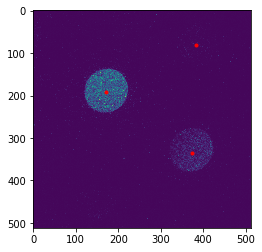

In [63]:
ExpPath = '/srv/home/chenyu/DEbackup/042219/S2/'
nSample = 18037
Sample = np.load(ExpPath+'npy/'+'S2_'+format(nSample,'05')+'.npy')
Sample_conv = FrameConv(Sample,mask_fft)
(loc_x,loc_y) = DiskLocate(Sample_conv)
plt.imshow(Sample)
plt.plot(loc_x, loc_y, 'r.')
print(loc_x, loc_y)

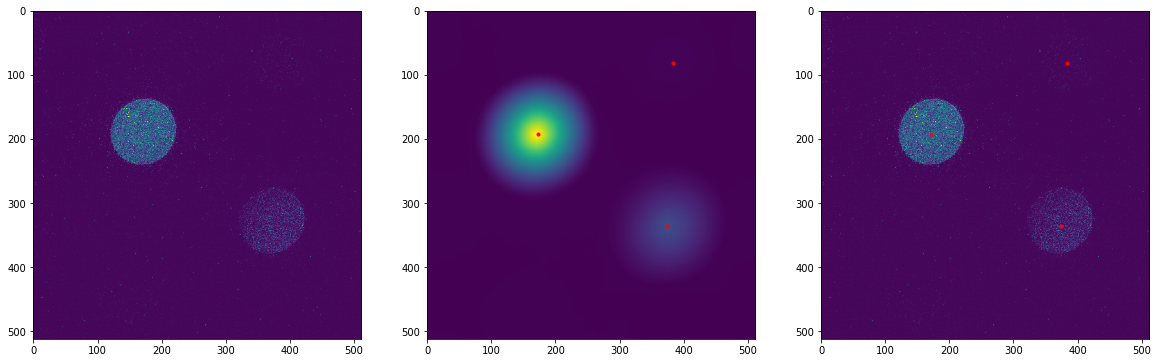

In [64]:
image_max = ndi.maximum_filter(Sample_conv, size=100, mode='constant')
coordinates = peak_local_max(Sample_conv, min_distance=50)

fig = plt.figure(figsize=(20,8))
fig.add_subplot(131)
plt.imshow(Sample)
fig.add_subplot(132)
plt.imshow(Sample_conv)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
fig.add_subplot(133)
plt.imshow(Sample)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

[154.27139800696074, 397.3016129207003, 168.8593098519806, 414.82333421358487] [434.43805198610875, 332.3489006517277, 221.63380469569842, 99.63517583231959]


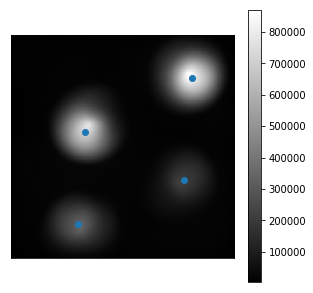

In [67]:
im = Sample_conv
peaks_x_fit = []
peaks_y_fit = []
for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])

    patch = im[y-50:y+50,x-50:x+50]
    bg = np.amin(patch)
    guess = (bg,patch[50,50]-bg,50, 50, 30, 30)
    bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,100,100,np.inf,np.inf])
    param = fitGaussianx2(patch, guess, bounds)

    peaks_x_fit.append(param[2]+x-50)
    peaks_y_fit.append(param[3]+y-50)

fig = plt.figure(figsize=(5,5))
im0 = plt.imshow(im,cmap=plt.cm.gray)
fig.colorbar(im0)
plt.scatter(peaks_x_fit,peaks_y_fit)
plt.xticks([])
plt.yticks([])
print(peaks_x_fit,peaks_y_fit)

In [1]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, patch.shape[1]-1, patch.shape[1])
    y = np.linspace(0, patch.shape[0]-1, patch.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt
